# Assignment 5 Xinan Wang

## 1. Create a custom decision tree model using the house pricing dataset(Used in the homework 3) (18 points)

 a) Split the dataset into training and test dataset 80:20

 b) Create a decision tree model for classification and prediction in python class format. Fit the model using training dataset. Show the model and provide proper interpretation on each node split.

 c) Predict the house prices using the test dataset, and provide the performance metrics. Compare your output with homework 3 output (Only performance metrics are fine. Do not need to repeat the code).

 d) Do you see any overfitting? How to overcome the overfitting issues? 

Note: Do not use any libraries

In [389]:
# import the required packages

%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [390]:
# Read the dataset

dfdata = pd.read_csv("houseprices.csv")
dfdata

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East
...,...,...,...,...,...,...,...,...
123,124,119700,1900,3,3,3,Yes,East
124,125,147900,2160,4,3,3,Yes,East
125,126,113500,2070,2,2,2,No,North
126,127,149900,2020,3,3,1,No,West


### Preprocessing

In [391]:
# Define features and labels
Y = dfdata.iloc[:,1].values

In [392]:
# Convert the text data to numeric
dummies = pd.get_dummies(dfdata[['Brick','Neighborhood']])

# Drop the column with the independent variable (Price), and columns for which we created dummy variables
X_ = dfdata.drop(['Brick', 'Neighborhood','Price','Home'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['Brick_Yes','Neighborhood_East','Neighborhood_North','Neighborhood_West']]], axis=1)

####  a) Split the dataset into training and test dataset 80:20

In [393]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size = 0.2,random_state=42)

####  b) Create a decision tree model for classification and prediction in python class format. Fit the model using training dataset. Show the model and provide proper interpretation on each node split.

In [394]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

In [395]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [396]:
# Reshape Ytrain

Ytrain = Ytrain.reshape(-1,1)

In [397]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(Xtrain,Ytrain)
regressor.print_tree()

X_7 <= 0.0 ? 386176979.9509189
 left:X_0 <= 2030.0 ? 94142473.21625966
  left:X_3 <= 2.0 ? 67329751.72901258
    left:X_0 <= 1790.0 ? 49784618.48400904
        left:111300.0
        right:125590.90909090909
    right:X_0 <= 1600.0 ? 47906352.66666669
        left:69100.0
        right:104420.83333333333
  right:X_5 <= 0.0 ? 90533632.93428111
    left:X_0 <= 2250.0 ? 93802983.47107443
        left:115610.0
        right:149300.0
    right:X_4 <= 0.0 ? 49135419.14682543
        left:131855.55555555556
        right:145985.7142857143
 right:X_4 <= 0.0 ? 179187299.7322945
  left:X_0 <= 2140.0 ? 89084681.73801506
    left:X_0 <= 1930.0 ? 23722623.966942146
        left:137900.0
        right:148025.0
    right:X_1 <= 3.0 ? 66381258.50340137
        left:180900.0
        right:157616.66666666666
  right:X_1 <= 3.0 ? 184671176.38771483
    left:X_0 <= 1830.0 ? 24229115.646258496
        left:151600.0
        right:165666.66666666666
    right:X_0 <= 2280.0 ? 104160555.55555557
        left:18

Explain the decision tree line by line:

* X_7 <= 0.0 ? 386176979.9509189  --> <b> [Neighborhood_West <= 0] (South, North, East) </b>
 * left:X_0 <= 2030.0 ? 94142473.21625966  --> <b> Left: [SqFt <= 2030] </b>
   * left:X_3 <= 2.0 ? 67329751.72901258  --> <b> Left: [Offers <= 2] </b> 
     * left:X_0 <= 1790.0 ? 49784618.48400904  --> <b> Left: [SqFt <= 1790] </b>
        * left:111300.0      
        * right:125590.90909090909      
     * right:X_0 <= 1600.0 ? 47906352.66666669  --> <b> Right: [SqFt <= 1600] </b>   
        * left:69100.0     
        * right:104420.83333333333
        
   * right:X_5 <= 0.0 ? 90533632.93428111  --> <b> Right: [Neighborhood_East <= 0] (South, North, West) </b>
      * left:X_0 <= 2250.0 ? 93802983.47107443  --> <b> Left: [SqFt <= 2250] </b> 
        * left:115610.0  
        * right:149300.0    
      * right:X_4 <= 0.0 ? 49135419.14682543  --> <b> Right: [Brick <= 0] (Brick is No) </b>  
        * left:131855.55555555556     
        * right:145985.7142857143 
 * right:X_4 <= 0.0 ? 179187299.7322945  --> <b> Right: [Brick <= 0] (Brick is No) </b>
   * left:X_0 <= 2140.0 ? 89084681.73801506  --> <b> Left: [SqFt <= 2140] </b>
     * left:X_0 <= 1930.0 ? 23722623.966942146  --> <b> Left: [SqFt <= 1930] </b>   
        * left:137900.0       
        * right:148025.0        
     * right:X_1 <= 3.0 ? 66381258.50340137  --> <b> Right: [Bedrooms <= 3] </b>  
        * left:180900.0     
        * right:157616.66666666666      
   * right:X_1 <= 3.0 ? 184671176.38771483  --> <b>Right: [Bedrooms <= 3]</b> 
     * left:X_0 <= 1830.0 ? 24229115.646258496  --> <b> Left: [SqFt <= 1830] </b> 
        * left:151600.0      
        * right:165666.66666666666     
     * right:X_0 <= 2280.0 ? 104160555.55555557  --> <b> Right: [SqFt <= 2280] </b>
        * left:183700.0    
        * right:205350.0

#### c) Predict the house prices using the test dataset, and provide the performance metrics. Compare your output with homework 3 output (Only performance metrics are fine. Do not need to repeat the code).



In [398]:
# Convert Xtest to numpy array

Xtest = Xtest.to_numpy()

In [399]:
# Predict the Xtest

Ypred = regressor.predict(Xtest)
Ypred

[111300.0,
 111300.0,
 165666.66666666666,
 125590.90909090909,
 148025.0,
 145985.7142857143,
 148025.0,
 104420.83333333333,
 183700.0,
 148025.0,
 183700.0,
 111300.0,
 137900.0,
 131855.55555555556,
 131855.55555555556,
 104420.83333333333,
 125590.90909090909,
 145985.7142857143,
 115610.0,
 69100.0,
 111300.0,
 104420.83333333333,
 104420.83333333333,
 125590.90909090909,
 157616.66666666666,
 104420.83333333333]

### Accuracy

##### (a) RMSE

In [400]:
from math import sqrt
def RMSE(YPredict, YTest):
    return sqrt(np.sum((YTest - YPredict)**2)/YTest.shape[0])

In [401]:
print('The RMSE of Decision Tree model is:', RMSE(Ypred, Ytest))

The RMSE of Decision Tree model is: 15080.064739193236


The RMSE of Linear Regression model is: 10683.698008960784. (Check the code in the belowing picture)

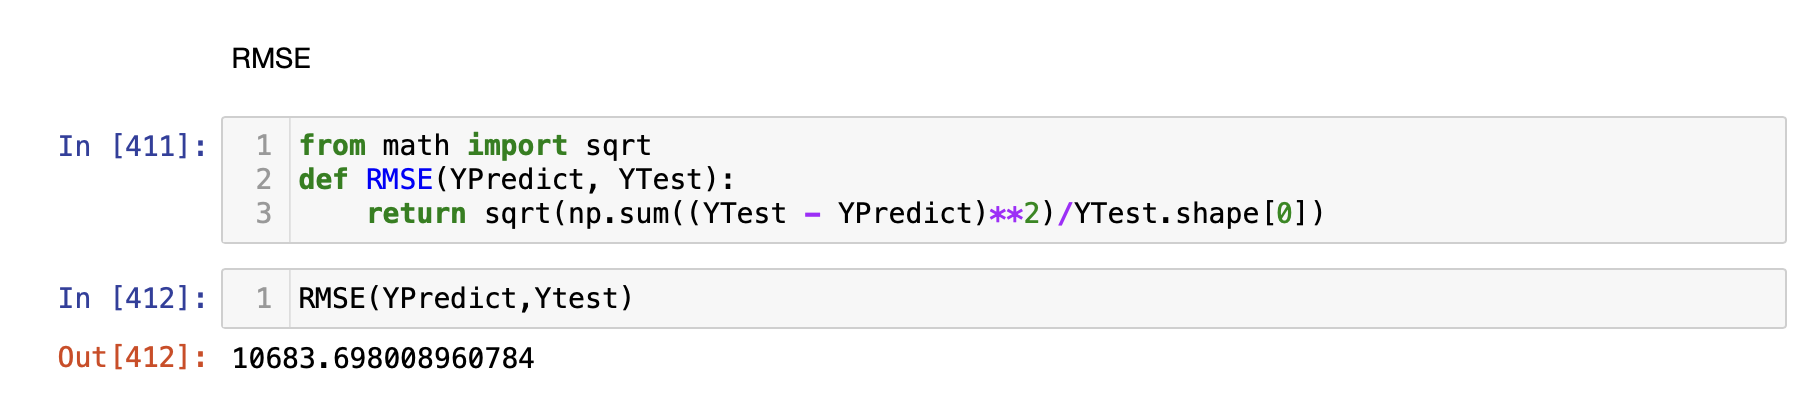

Therefore,

* The RMSE of Decision Tree model is 15080.0647
* The RMSE of Linear Regression model is 10683.6980
* Linear Regression model RMSE < Decision Tree model RMSE

The RMSE is the standard deviation of the predicted errors. It measures how close the regression line is to a set of data points. The lower the RMSE, the better a given model is be able to "fit" a dataset. From the output, we can see that the RMSE of Decision Tree(15080.0647) is extremely larger than the RMSE of Linear Regression Model(10683.6980). It means that compared to the linear regression model, the decision tree regression model perform worse. The decision tree model has a worse performance on predicting the test dataset, and the accuracy of the decision model is worse than the linear regression model.

From the output, we can see that the mean squred error of the decision tree model is 15080.

In [402]:
def r2score(y_pred, y):
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    
    r2 = 1 - (rss / tss)
    return r2

In [403]:
# r2score for YPred and the real Y
print('The R2 score of Decision Tree model is:', r2score(Ypred,Ytest))

The R2 score of Decision Tree model is: 0.6141690183149361


The R2 score of Linear Regression model is: 0.806342690866721. (Check the code in the belowing picture)

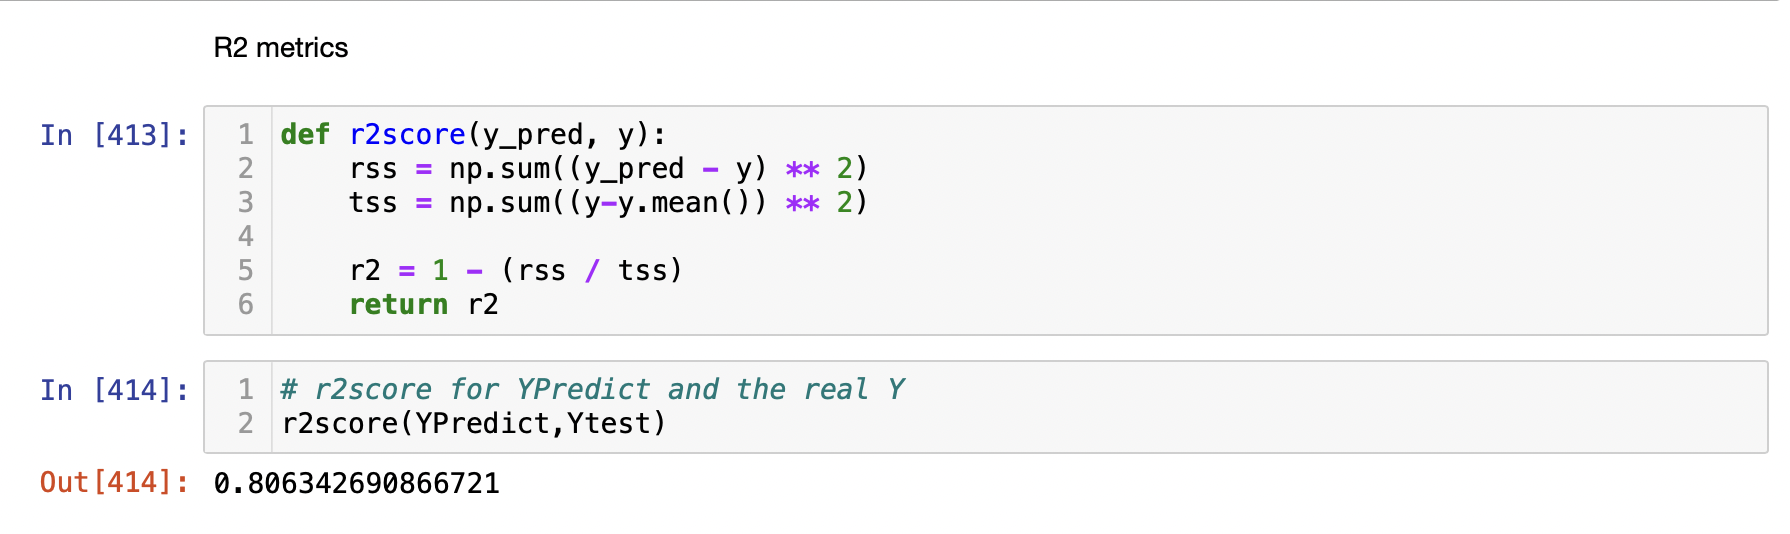

Therefore,

* The R2 score of the decision tree model is 0.6142
* The R2 score of the linear regression model is 0.8063
* Linear Regression R2 score > Decision Tree R2 score


R2 is a measure of the goodness of fit of a model. It is a statistical measure of how well the regression predictions approximate the real data points. The higher the R2 score (the more approach to 1), the better fit the data. From the R2 score output, we can find that the linear regression r2 score is 0.8063. It means the model has around 80.63% accuracy to the Xtest dataset, which is a pretty good performance. However, the decision tree model r2 score only get 0.6142, which means the model has around 61.42% accuracy to the Xtest dataset. This performance is smaller than the linear regression model. Therefore, It matches the result we get from the RMSE comparison that the decision tree model has worse performance than the linear regression model, and the accuracy of the decision tree model is worse than the linear regression model.

####  d) Do you see any overfitting? How to overcome the overfitting issues? 

In [404]:
# Predict the Xtrain dataset

Xtrain = Xtrain.values
Train_pred = regressor.predict(Xtrain)
Train_pred

[165666.66666666666,
 115610.0,
 115610.0,
 111300.0,
 104420.83333333333,
 104420.83333333333,
 148025.0,
 145985.7142857143,
 131855.55555555556,
 111300.0,
 104420.83333333333,
 137900.0,
 183700.0,
 104420.83333333333,
 165666.66666666666,
 111300.0,
 165666.66666666666,
 183700.0,
 157616.66666666666,
 104420.83333333333,
 104420.83333333333,
 145985.7142857143,
 115610.0,
 149300.0,
 104420.83333333333,
 69100.0,
 125590.90909090909,
 131855.55555555556,
 115610.0,
 111300.0,
 115610.0,
 131855.55555555556,
 111300.0,
 104420.83333333333,
 115610.0,
 145985.7142857143,
 145985.7142857143,
 104420.83333333333,
 183700.0,
 157616.66666666666,
 125590.90909090909,
 137900.0,
 125590.90909090909,
 104420.83333333333,
 131855.55555555556,
 115610.0,
 131855.55555555556,
 104420.83333333333,
 104420.83333333333,
 137900.0,
 104420.83333333333,
 104420.83333333333,
 151600.0,
 131855.55555555556,
 111300.0,
 104420.83333333333,
 104420.83333333333,
 145985.7142857143,
 125590.9090909090

In [406]:
# r2score for YPred and the real Y
from sklearn.metrics import r2_score
print('The R2 score of Decision Tree for training dataset is:', r2_score(Ytrain,Train_pred))
print('The R2 score of Decision Tree for validation is:', r2_score(Ytest,Ypred))

The R2 score of Decision Tree for training dataset is: 0.8717378462209808
The R2 score of Decision Tree for validation is: 0.6141690183149361


From the output of the training dataset R2 score and the validation dataset R2 score, we find that the training data can approach to around 87.1738% accuracy on the data. However, our prediction dataset only has 61.4169% accuracy, which has a great difference between the training dataset and the testing dataset. Therefore, there is a overfitting on our model.

By decrease overfitting, we could do pruning for decision tree models. We can apply pre-pruning method or the post-pruning method.

## 2.  Classify homework 4 dataset with the decision tree model(17 points)

 a) Fit the decision tree model with RINGS as a response variable. How is the model performance? How do you interpret the model?

 b) Fit the decision tree with the custom response variable which you created in homework 4. Compare the model performance against logistic regression model (Only performance metrics are fine. Do not need to repeat the code)? Do you find any interesting insights on decision tree model? Which model do you choose for this dataset?

c) If you would like to improve the performance of the decision tree using this model, what steps do you recommend?

d) What hyperparameters can you use for model optimization in the decision tree?

e) How do you control the depth of the decision tree in your custom model?

Note: Do not use any libraries

In [478]:
# import the required packages

%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [479]:
# import the dataset
dfdata = pd.read_csv("abalone.data")
dfdata

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200,8
...,...,...,...,...,...,...,...,...,...
4171,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4172,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4173,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4174,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [480]:
# Get the top row of the dataset
new_row = dfdata.columns
new_row = pd.DataFrame(new_row).T
new_row.columns = ['SEX','LENGTH','DIAM','HEIGHT','WHOLE','SHUCK','VISCERA','SHELL','RINGS']
new_row

,SEX,LENGTH,DIAM,HEIGHT,WHOLE,SHUCK,VISCERA,SHELL,RINGS
0,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15


In [481]:
# Add the top row to the dataset and change the column name of the dataset
dfdata.columns = ['SEX','LENGTH','DIAM','HEIGHT','WHOLE','SHUCK','VISCERA','SHELL','RINGS']
dfdata = pd.concat([new_row,dfdata]).reset_index(drop = True)
dfdata

,SEX,LENGTH,DIAM,HEIGHT,WHOLE,SHUCK,VISCERA,SHELL,RINGS
0,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
1,M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7
2,F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9
3,M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10
4,I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.45,0.165,0.887,0.37,0.239,0.249,11
4173,M,0.59,0.44,0.135,0.966,0.439,0.2145,0.2605,10
4174,M,0.6,0.475,0.205,1.176,0.5255,0.2875,0.308,9
4175,F,0.625,0.485,0.15,1.0945,0.531,0.261,0.296,10


In [482]:
# Check the type of the columns
dfdata.dtypes

SEX        object
LENGTH     object
DIAM       object
HEIGHT     object
WHOLE      object
SHUCK      object
VISCERA    object
SHELL      object
RINGS      object
dtype: object

In [483]:
# Change the type of the columns

dfdata['LENGTH'] = dfdata['LENGTH'].astype(float)
dfdata['DIAM'] = dfdata['DIAM'].astype(float)
dfdata['HEIGHT'] = dfdata['HEIGHT'].astype(float)
dfdata['WHOLE'] = dfdata['WHOLE'].astype(float)
dfdata['SHUCK'] = dfdata['SHUCK'].astype(float)
dfdata['VISCERA'] = dfdata['VISCERA'].astype(float)
dfdata['SHELL'] = dfdata['SHELL'].astype(float)
dfdata['RINGS'] = dfdata['RINGS'].astype(int)
dfdata.dtypes

SEX         object
LENGTH     float64
DIAM       float64
HEIGHT     float64
WHOLE      float64
SHUCK      float64
VISCERA    float64
SHELL      float64
RINGS        int64
dtype: object

In [484]:
# Add the AGE column based on RINGS column

dfdata['AGE'] = dfdata['RINGS'] + 1.5
dfdata

,SEX,LENGTH,DIAM,HEIGHT,WHOLE,SHUCK,VISCERA,SHELL,RINGS,AGE
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5


In [485]:
# Add the CLASS column into the dataset based on the AGE column
diff = float((30.5 - 2.5)/6)

CLASS = []

for row in dfdata['AGE']:
        if row < diff: CLASS.append('A1')
        elif row < (2 * diff): CLASS.append('A2')
        elif row < (3 * diff): CLASS.append('A3')
        elif row < (4 * diff): CLASS.append('A4')
        elif row < (5 * diff): CLASS.append('A5')
        else: CLASS.append('A6')

dfdata['CLASS'] = CLASS
dfdata

,SEX,LENGTH,DIAM,HEIGHT,WHOLE,SHUCK,VISCERA,SHELL,RINGS,AGE,CLASS
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5,A4
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5,A2
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5,A3
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5,A3
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5,A2
...,...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5,A3
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5,A3
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5,A3
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5,A3


In [486]:
# Define features and labels

Yclass = dfdata.iloc[:,-1].values
Yrings = dfdata.iloc[:,-3].values
X = dfdata.iloc[:,:-3].values

In [487]:
# Convert text data to numbers

dummies = pd.get_dummies(dfdata[['SEX']])
X_ = dfdata.drop(['SEX','RINGS','CLASS','AGE'], axis=1).astype('float64')
X = pd.concat([X_, dummies[['SEX_F','SEX_M','SEX_I']]], axis=1)
X

,LENGTH,DIAM,HEIGHT,WHOLE,SHUCK,VISCERA,SHELL,SEX_F,SEX_M,SEX_I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,1,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,1,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,1,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,1,0
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,1,0
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0


#### a) Fit the decision tree model with RINGS as a response variable. How is the model performance? How do you interpret the model?

In [488]:
# Split the dataset into training and testing

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Yrings, test_size = 0.2,random_state=42)

In [450]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

In [451]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [452]:
# Reshape Ytrain
Ytrain = Ytrain.reshape(-1,1)

In [453]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(Xtrain,Ytrain)
regressor.print_tree()

X_6 <= 0.1545 ? 2.9199866730083004
 left:X_6 <= 0.047 ? 1.0623522508481842
  left:X_6 <= 0.0215 ? 0.6454595517239485
    left:X_3 <= 0.023 ? 0.22597322337397918
        left:3.230769230769231
        right:4.446428571428571
    right:X_1 <= 0.22 ? 0.11885956977906642
        left:5.670329670329671
        right:6.381818181818182
  right:X_9 <= 0.0 ? 0.5225680286137515
    left:X_4 <= 0.232 ? 0.32495126134452645
        left:9.168032786885245
        right:7.679245283018868
    right:X_6 <= 0.1115 ? 0.3052049578856324
        left:6.991354466858789
        right:8.151351351351352
 right:X_6 <= 0.3745 ? 0.9331186043069506
  left:X_6 <= 0.254 ? 0.32076830540875
    left:X_4 <= 0.281 ? 0.4457499472110795
        left:10.786377708978328
        right:9.419678714859439
    right:X_4 <= 0.4435 ? 0.9500525454472566
        left:12.269633507853403
        right:10.285457809694794
  right:X_4 <= 0.55 ? 1.5467172627206622
    left:X_6 <= 0.413 ? 1.675145876324878
        left:13.51388888888889
  

Interpret the model line by line: 

 * X_6 <= 0.1545 ? 2.9199866730083004  --> <b>Shell <= 0.1545 </b>
   * left:X_6 <= 0.047 ? 1.0623522508481842  --> <b>Left: Shell <= 0.047 </b>
     * left:X_6 <= 0.0215 ? 0.6454595517239485  --> <b>Left: Shell <= 0.0215 </b>
       * left:X_3 <= 0.023 ? 0.22597322337397918  --> <b>Left: Whole <= 0.023 </b>
         * left:3.230769230769231
         * right:4.446428571428571
       * right:X_1 <= 0.22 ? 0.11885956977906642  --> <b>Right: DIAM <= 0.22 </b>
         * left:5.670329670329671
         * right:6.381818181818182
     * right:X_9 <= 0.0 ? 0.5225680286137515  --> <b>Right: Sex_I <= 0 (Sex is F or M) </b>
       * left:X_4 <= 0.232 ? 0.32495126134452645  --> <b>Left: Shuck <= 0.232 </b>
         * left:9.168032786885245
         * right:7.679245283018868
       * right:X_6 <= 0.1115 ? 0.3052049578856324  --> <b>Right: Shell <= 0.1115 </b>
         * left:6.991354466858789
         * right:8.151351351351352
   * right:X_6 <= 0.3745 ? 0.9331186043069506  --> <b>Right: Shell <= 0.3745 </b>
     * left:X_6 <= 0.254 ? 0.32076830540875  --> <b>Left: Shell <= 0.254 </b>
       * left:X_4 <= 0.281 ? 0.4457499472110795  --> <b>Left: Shuck <= 0.281 </b>
         * left:10.786377708978328
         * right:9.419678714859439
       * right:X_4 <= 0.4435 ? 0.9500525454472566  --> <b>Right: Shuck <= 0.4435 </b>
         * left:12.269633507853403
         * right:10.285457809694794
     * right:X_4 <= 0.55 ? 1.5467172627206622  --> <b>Right: Shuck <= 0.55 </b>
       * left:X_6 <= 0.413 ? 1.675145876324878  --> <b>Left: Shell <= 0.413 </b>
         * left:13.51388888888889
         * right:16.103896103896105
       * right:X_6 <= 0.5675 ? 1.1147865905451724  --> <b>Right: Shell <= 0.5675 </b>
         * left:11.645645645645645
         * right:14.672727272727272

In [459]:
Xtest = Xtest.values
Ypred = regressor.predict(Xtest)
Ypred

[12.269633507853403,
 9.419678714859439,
 12.269633507853403,
 13.51388888888889,
 10.786377708978328,
 10.786377708978328,
 10.786377708978328,
 9.419678714859439,
 6.991354466858789,
 12.269633507853403,
 12.269633507853403,
 6.991354466858789,
 10.786377708978328,
 6.991354466858789,
 9.419678714859439,
 12.269633507853403,
 12.269633507853403,
 10.786377708978328,
 11.645645645645645,
 7.679245283018868,
 14.672727272727272,
 11.645645645645645,
 10.285457809694794,
 10.285457809694794,
 9.419678714859439,
 8.151351351351352,
 10.786377708978328,
 7.679245283018868,
 9.419678714859439,
 12.269633507853403,
 11.645645645645645,
 10.285457809694794,
 6.991354466858789,
 10.786377708978328,
 8.151351351351352,
 9.419678714859439,
 6.381818181818182,
 3.230769230769231,
 7.679245283018868,
 6.381818181818182,
 11.645645645645645,
 14.672727272727272,
 12.269633507853403,
 10.786377708978328,
 12.269633507853403,
 11.645645645645645,
 10.285457809694794,
 9.419678714859439,
 12.26963350

RMSE

In [460]:
from math import sqrt
def RMSE(YPredict, YTest):
    return sqrt(np.sum((YTest - YPredict)**2)/YTest.shape[0])
print('The RMSE of Decision Tree model of Rings is:', RMSE(Ypred, Ytest))

The RMSE of Decision Tree model of Rings is: 2.39684159867722


R2 Score

In [462]:
def r2score(y_pred, y):
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    
    r2 = 1 - (rss / tss)
    return r2
print('The R2 score of Decision Tree model of Rings is:', r2score(Ypred,Ytest))

The R2 score of Decision Tree model of Rings is: 0.46930825129743003


From the output, we can see that the r2score of the prediction model is 0.469308, which means our model have 46.93% accuracy on the testing data. This performance isn't very good because it can't even predict 50% of the testing data correctly.

####  b) Fit the decision tree with the custom response variable which you created in homework 4. Compare the model performance against logistic regression model (Only performance metrics are fine. Do not need to repeat the code)? Do you find any interesting insights on decision tree model? Which model do you choose for this dataset?

In [489]:
# Split the dataset into training and testing

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Yclass, test_size = 0.2,random_state=1234)

In [490]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [491]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [492]:
Ytrain = Ytrain.reshape(-1,1)

In [470]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(Xtrain,Ytrain)
classifier.print_tree()

X_6 <= 0.1195 ? 0.10843655302629729
 left:X_9 <= 0.0 ? 0.050428383750214634
  left:X_6 <= 0.05 ? 0.12639117882361123
    left:X_3 <= 0.023 ? 0.03723905723905732
        left:A1
        right:A2
    right:X_4 <= 0.194 ? 0.03437606292517004
        left:A3
        right:A2
  right:X_6 <= 0.067 ? 0.02405164969590018
    left:X_4 <= 0.007 ? 0.03063342807524136
        left:A1
        right:A2
    right:X_2 <= 0.1 ? 0.010334945030772313
        left:A2
        right:A2
 right:X_6 <= 0.354 ? 0.01042423099565859
  left:X_4 <= 0.4435 ? 0.010072471701117525
    left:X_6 <= 0.279 ? 0.020187851782230648
        left:A3
        right:A3
    right:X_3 <= 1.58 ? 0.007526319179651686
        left:A3
        right:A4
  right:X_4 <= 0.4835 ? 0.03838164254152271
    left:X_1 <= 0.425 ? 0.03093787983455598
        left:A5
        right:A4
    right:X_6 <= 0.5085 ? 0.02996547345185352
        left:A3
        right:A3


Interpret the decision tree model line by line:

* X_6 <= 0.1195 ? 0.10843655302629729  --> <b>Shell <= 0.1195</b>
    * left:X_9 <= 0.0 ? 0.050428383750214634  --> <b> Left: Sex_I <= 0 (Sex is F or M)</b>
    * left:X_6 <= 0.05 ? 0.12639117882361123  --> <b>Left: Shell <= 0.05 </b>
      * left:X_3 <= 0.023 ? 0.03723905723905732  --> <b>Left: Whole <= 0.023 </b>
         * left:A1
         * right:A2
      * right:X_4 <= 0.194 ? 0.03437606292517004 --> <b>Right: Shuck <= 0.194 </b>
         * left:A3
         * right:A2
    * right:X_6 <= 0.067 ? 0.02405164969590018  --> <b>Right: Shell <= 0.067 </b>
      * left:X_4 <= 0.007 ? 0.03063342807524136 --> <b>Left: Shuck <= 0.007 </b>
         * left:A1
         * right:A2
      * right:X_2 <= 0.1 ? 0.010334945030772313 --> <b>Right: Height <= 0.1 </b>
         * left:A2
         * right:A2
   * right:X_6 <= 0.354 ? 0.01042423099565859  --> <b>Left: Shell <= 0.354 </b>
     * left:X_4 <= 0.4435 ? 0.010072471701117525  --> <b>Left: Shuck <= 0.4435 </b>
       * left:X_6 <= 0.279 ? 0.020187851782230648  --> <b>Left: Shell <= 0.279 </b>
         * left:A3
         * right:A3
       * right:X_3 <= 1.58 ? 0.007526319179651686  --> <b>Right: Whole <= 1.58 </b>
         * left:A3
         * right:A4
     * right:X_4 <= 0.4835 ? 0.03838164254152271  --> <b>Right: Shuck <= 0.4835 </b>
       * left:X_1 <= 0.425 ? 0.03093787983455598   --> <b>Left: Length <= 0.425 </b>
         * left:A5
         * right:A4
       * right:X_6 <= 0.5085 ? 0.02996547345185352  --> <b>Right: Shell <= 0.5085 </b>
         * left:A3
         * right:A3

In [493]:
Xtest = Xtest.values

In [494]:
Ypred = classifier.predict(Xtest)
Ypred

['A3',
 'A3',
 'A2',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A2',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A1',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A2',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A2',
 'A2',
 'A2',
 'A3',
 'A4',
 'A3',
 'A2',
 'A4',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A2',
 'A3',
 'A3',
 'A2',
 'A2',
 'A3',
 'A3',
 'A2',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A4',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A4',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A3',
 'A2',
 'A3',
 'A3',
 'A2',

Confusion_matrix

In [499]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Ytest,Ypred))

[[  2   1   0   0   0   0]
 [  4 118  45   0   0   0]
 [  0  36 492   9   0   0]
 [  0   0  90   9   0   0]
 [  0   0  21   5   0   0]
 [  0   0   3   1   0   0]]


The confusion matrix output from the HW4:

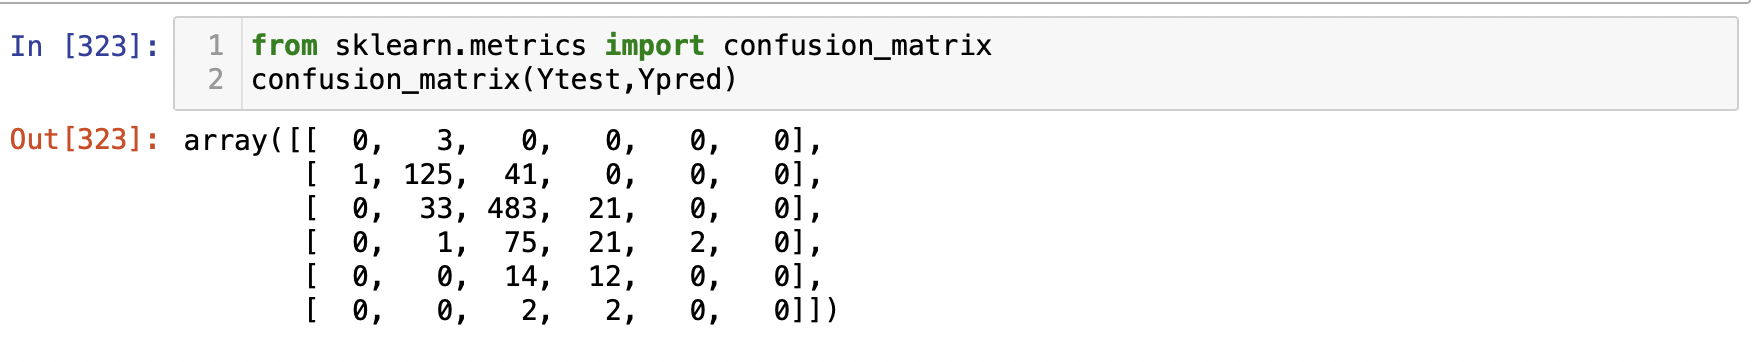

Accuracy

In [496]:
def accuracy(y_pred, y_test):
    return round(np.sum(y_pred==y_test)/len(y_test),5)

acc = accuracy(Ypred, Ytest)
print(acc)

0.74282


The accuracy output from HW4:

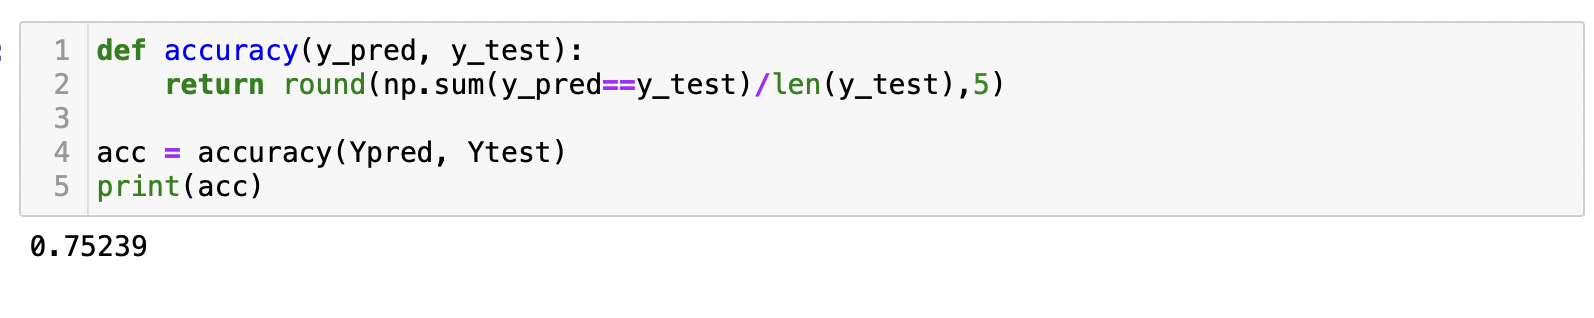

From the previous output, we can see that the accuracy of the decision tree model is 0.74282, which means our model overall accuracy is around 74.28%. This is a good performance. Compared to the logistic regression model, we just get a little bit lower accuracy since 74.28% is just around 1% decrease compared with 75.24%. Therefore, there's no very large accuracy difference between logistic regression model and the decision tree model.

However, by checking the confusion matrix output, we can see that compared to the logistic regression model, the output of the decision tree model are much more likely to be concentrated on A1, A2 and A3. Also, even though we didn't get 80% or higher performance, by checking the confusion matrix, we can see that most of the wrong predicted class has been predicted to the nearest classes of the real class. So, our model didn't do bad in predicting this dataset.

Because the accuracy of the decision tree model and the logistic regression model doesn't matter too much. But I will use logistic regression since it's much more accurate.

The interesting insight that I've found from this is that it seems that the decision tree classification is much more accurate compared to the decision tree regression. With decision tree regression model, it will be a little hard to reach 75% accuracy.

#### c) If you would like to improve the performance of the decision tree using this model, what steps do you recommend?



I will develop a decision tree model firstly with the default min_sample_split and max_depth. Then, I will use a for loop to record each prediction accuracy for different min_sample_split and max_depth inputs. Next, I will pick up a good accuracy with a good balance between underfitting and overfitting, and it also need to have a good accuracy on the testing model. Then, I will use the corresponding hyperparameter on my decision tree model and do the next step analysis.

#### d) What hyperparameters can you use for model optimization in the decision tree?

In this model, we can tune the min_sample_split and the max_depth hyperparameter to optimize the decision tree model. the min_sample_split is the minimum number of samples required to split a node, and the max_depth is the maximum depth of the decision tree. We can start to construct a decision tree with a small max_depth, and then try the max_depth larger and larger, to balance the underfitting and overfitting of our model. The min_sample_split can be used to expand or faltten the decision tree. Finally, ideally we would like to get a decision tree that have a perfect balance between overfitting and underfitting, and has the global minimum of testing error.

#### e) How do you control the depth of the decision tree in your custom model?

I will develop a for loop and try many numbers of tree depths. I will train the decision tree by using each of the depth on training data and testing data, and then keep the training error and the testing error. Then, I will find the global minimum of the testing error. And I will find out the corresponding depth I use to generate the global minimum testing error, and use it as the depth of the model.

In [503]:
Xtrain = Xtrain.values

In [506]:
from sklearn.metrics import accuracy_score
for i in range(1, 10):
  classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=i)
  classifier.fit(Xtrain,Ytrain)
  Ypredict = classifier.predict(Xtest)
  train_predict = classifier.predict(Xtrain)
  test_acc = accuracy(Ytest, Ypredict)
  train_acc = accuracy_score(Ytrain, train_predict)
  print('max_depth=%d, train: %f, test: %f' %(i, train_acc, test_acc))

max_depth=1, train: 0.729123, test: 0.745220
max_depth=2, train: 0.747680, test: 0.748800
max_depth=3, train: 0.752769, test: 0.742820
max_depth=4, train: 0.766537, test: 0.732060
max_depth=5, train: 0.776414, test: 0.734450
max_depth=6, train: 0.790183, test: 0.726080
max_depth=7, train: 0.814128, test: 0.720100
max_depth=8, train: 0.838372, test: 0.722490
max_depth=9, train: 0.863813, test: 0.711720
